In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lognormal_mocks import *
from scipy.stats import skew
from scipy import integrate


In [2]:

import sys 
sys.path.append('/scripts/')

import cosmo as co
import kernels as kn

In [24]:
def get_kappa_bar(cosmo, z, pz,npts):
    """
    Compute the kappa bar of the field, which:
    
    kappabar = int dz W(z)/D(z), where W(z) is the lensing kernel and D(z)
    is the normalized growth factor. 
     
    Attributes
    ----------
    
    cosmo: Cosmo object computed from Cosmology class
    z : Array of redshifts
    pz : Array of weights
    npts: number of points to perform the integration
    """
    zmin = 0.0
    zmax = np.max(z)    
    DNDZ = kn.dNdz(z, pz, z_min= zmin, z_max=zmax)
    lens_obj = kn.LensGal(cosmo, DNDZ)
  
    chis = np.linspace(zmin, cosmo.f_K(zmax), npts)
    zs   = cosmo.bkd.redshift_at_comoving_radial_distance(chis) #redshifts from the comoving distance
    zs   =  zs[1:-1]
    
    d_factor = cosmo.D_z_norm(zs) #growth factor
    
    Wz = lens_obj.raw_W_z(zs) #lensing kernel
    kbar = integrate.simps(Wz/d_factor, x= zs)
    
    return kbar

In [2]:
#To simulate the galaxy convergence maps, we need to define some important parameters:

nside = 1024 #Resolution of output maps
lmax = 3*nside
npix = hp.nside2npix(nside)
omegapix = 4*np.pi/npix
Ntheta = 50000 # Accuracy parameter- Mainly important to recover small scales. Increase if you will work with higher resolution
kappabar = 100.0 # a large, fake mean kappa value makes the kappa field more gaussian, it is subtracted away in the end


In [25]:
#We need to define "kappa-bar" as the  lowest possible value of kappa, and we can obtain it 
#theoretically from a specific redshift distribution and
#cosmology, by doing, for example:

z,pz  = np.loadtxt('/data/pz_des_all_z2.txt')
cosmo = co.Cosmology(nonlinear=True)#change the default if you don't have something like Planck 2018 params

kgalbar = get_kappa_bar(cosmo, z,pz,300) #<--we will use it in the lognormal code



0.9941341222633326


# Theoretical auto and cross- Cls

In [7]:
#Get theoretical calls from your preferred code:

import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c= 0.267809998, Omega_b=0.049401506, h=0.6702393 , A_s=2.15086031154146e-9, n_s=0.9625356, Neff=3.06,
                      matter_power_spectrum='halofit')

#CMB lensing object
cmbl = ccl.CMBLensingTracer(cosmo, 1090.)


#Galaxy lensing object assuming this dndz:
lens = ccl.WeakLensingTracer(cosmo,dndz)

#Power spectra:
ell = np.arange(0,  lmax)

cl_kgal_th = ccl.angular_cl(cosmo, lens,lens, ell)
cls_kgalkcmb_th = ccl.angular_cl(cosmo, lens,cmbl, ell)
cls_kcmb_th = ccl.angular_cl(cosmo, cmbl,cmbl, ell)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Skewness of GRF CMBlens= -0.0011267262563272114 Skewness of GRF Gal.lens= -0.0010088743133755296


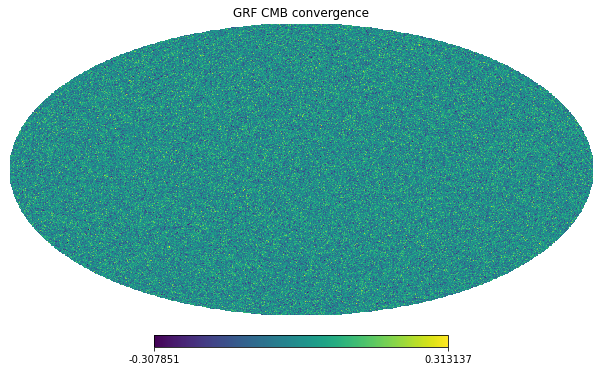

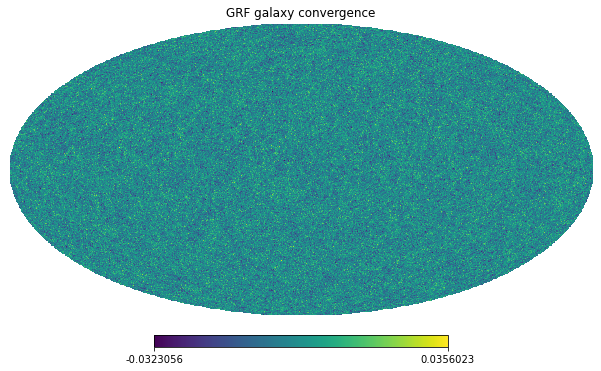

In [8]:
#Just to have an idea, let's produce a gaussian random field from the input power spectrum:


kcmb_grf = hp.synfast(cls_kcmb_th, nside, lmax)
kgal_grf = hp.synfast(cl_kgal_th , nside, lmax)

hp.mollview(kcmb_grf,title='GRF CMB convergence')
hp.mollview(kgal_grf, title='GRF galaxy convergence')

print( 'Skewness of GRF CMBlens=', skew(kcmb_grf),'Skewness of GRF Gal.lens=', skew(kgal_grf))

# Log-normal code:

In [9]:
rhobar = np.array([kgalbar, kappabar])  # array of mean must be size of number of maps


Cl = np.array([[cl_kgal_th, cls_kgalkcmb_th ],
            [cls_kgalkcmb_th, cls_kcmb_th]])  # array of input Cl must be size (Nmap, Nmap, Nl).  If this is the wrong shape it will fail 

gaussbar, Clgauss = lognormal_mocks_stats(rhobar,Cl,Ntheta) # get the stats for the Gaussianized fields

almgauss = hp.synalm((Clgauss[0,0],Clgauss[1,1],Clgauss[1,0]),
            new=True) # make the correlated, gaussianized alms


kgal_gauss = hp.alm2map(almgauss[0],nside) # synthesize the gaussianize maps
kcmb_gauss = hp.alm2map(almgauss[1],nside)



# exponentiate to get the non-gaussian maps
kappa_gal = np.exp(gaussbar[0] + kgal_gauss)- kgalbar # This is the  almost mean-zero kappa field
kappa_cmb = np.exp(gaussbar[1] + kcmb_gauss) - kappabar # This is the almost mean-zero kappa map


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


Skewness of GRF CMBlens= -0.0011267262563272114 Skewness of GRF Gal.lens= -0.0010088743133755296
Skewness of log CMBlens= 0.0025449091002015083 Skewness of  log Gallens= 1.1536015643970199


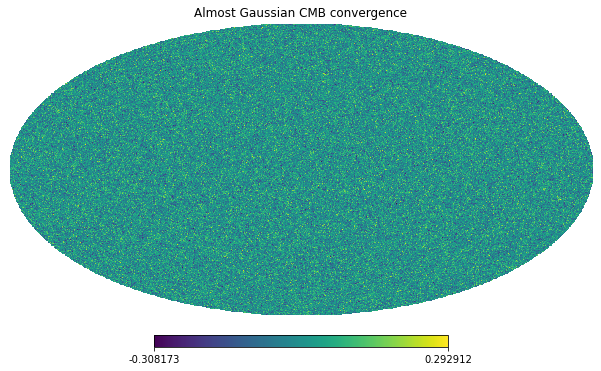

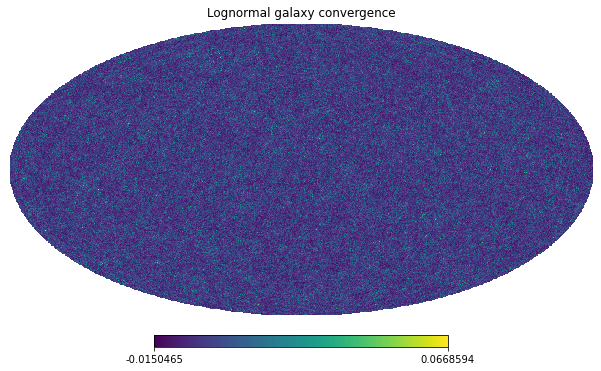

In [11]:
hp.mollview(kappa_cmb , title='Almost Gaussian CMB convergence')
hp.mollview(kappa_gal , title='Lognormal galaxy convergence')


print( 'Skewness of GRF CMBlens=', skew(kcmb_grf),'Skewness of GRF Gal.lens=', skew(kgal_grf))
print( 'Skewness of log CMBlens=', skew(kappa_cmb),'Skewness of  log Gallens=', skew(kappa_gal))


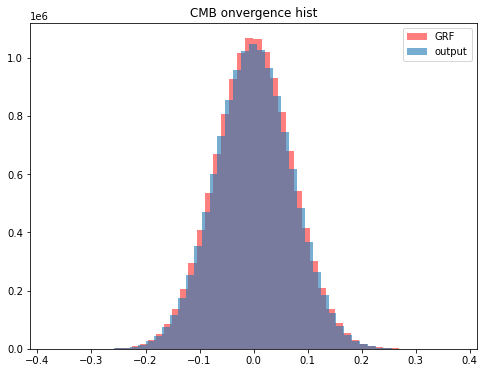

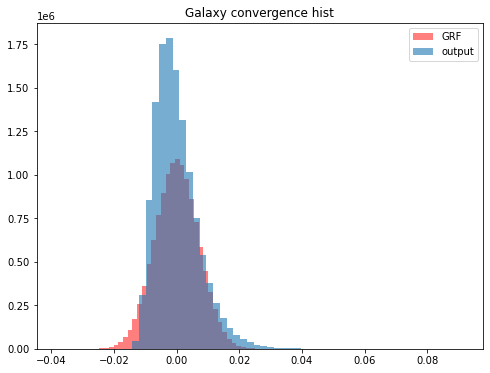

In [12]:
plt.figure(figsize=(8,6))
plt.hist(kcmb_grf, bins= 50,color='r', alpha=0.5, label='GRF')
plt.hist(kappa_cmb, alpha=0.6,  bins= 50, label='output')
plt.legend()
plt.title('CMB onvergence hist')
plt.show()


plt.figure(figsize=(8,6))
plt.hist(kgal_grf, bins= 50,color='r',alpha=0.5, label='GRF')
plt.hist(kappa_gal,alpha=0.6,  bins= 50, label='output')
plt.legend()
plt.title('Galaxy convergence hist')
plt.show()

In [13]:
 
clkgal_out = hp.anafast(kappa_gal)
clkgalkcmb_out = hp.anafast(kappa_gal, kappa_cmb)
clkcmb_out = hp.anafast(kappa_cmb, kappa_cmb)


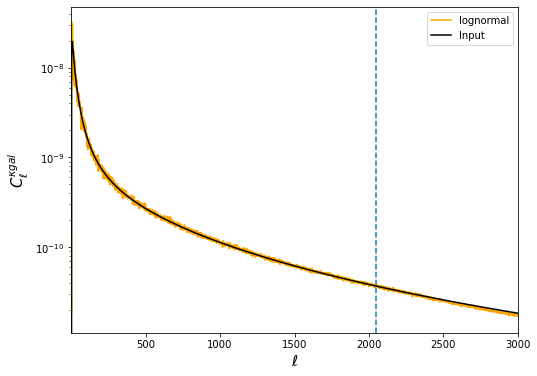

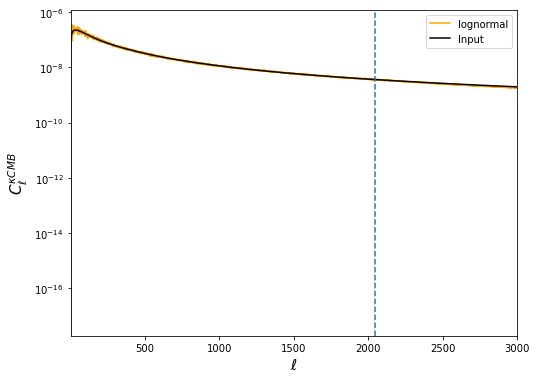

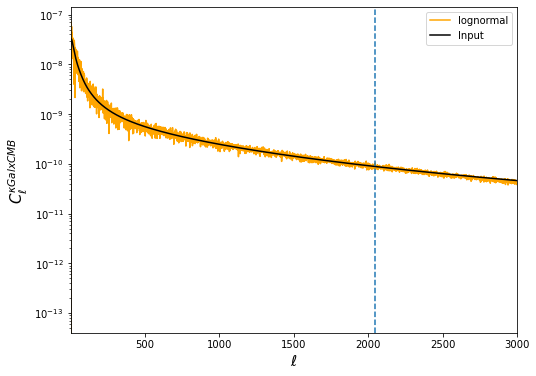

In [14]:
#Can we recover the input power spectrum? It seems that it is working, at least to lmax= 2*nside (which is ~healpy good precision)
plt.figure(figsize=(8,6))
plt.plot(clkgal_out ,color='orange',label='lognormal')
plt.plot(cl_kgal_th,color='k',label='Input')
plt.yscale('log')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}^{\kappa gal}$',fontsize=15)
plt.xlim(1,3000)
plt.axvline(2*nside, linestyle='dashed')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(clkcmb_out ,color='orange',label='lognormal')
plt.plot(cls_kcmb_th,color='k',label='Input')
plt.yscale('log')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}^{\kappa CMB}$',fontsize=15)
plt.xlim(1,3000)
plt.axvline(2*nside, linestyle='dashed')
plt.legend()
plt.show()



plt.figure(figsize=(8,6))
plt.plot(clkgalkcmb_out ,color='orange',label='lognormal')
plt.plot(cls_kgalkcmb_th,color='k',label='Input')
plt.yscale('log')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}^{\kappa Gal x CMB}$',fontsize=15)
plt.xlim(1,3000)
plt.axvline(2*nside, linestyle='dashed')
plt.legend()
plt.show()

/home/gmarques/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


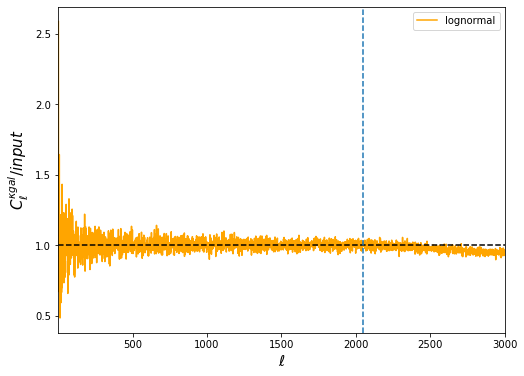

/home/gmarques/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


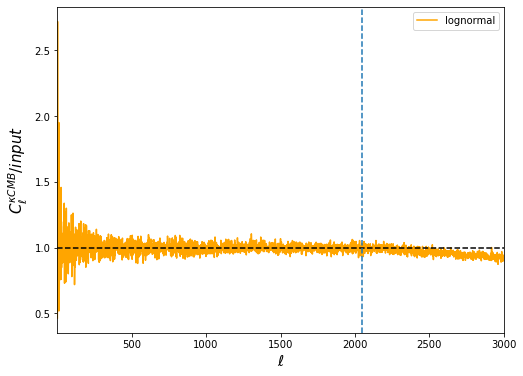

/home/gmarques/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


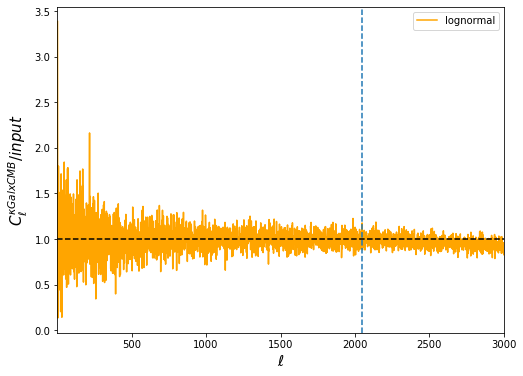

In [15]:
#Can we recover the input power spectrum? It seems that it is working, at least to lmax= 2*nside (which is ~healpy good precision)
plt.figure(figsize=(8,6))
plt.plot(clkgal_out/cl_kgal_th ,color='orange',label='lognormal')
plt.xlabel(r'$\ell$',fontsize=15)
plt.axhline(1, color='k',linestyle='dashed')
plt.ylabel(r'$C_{\ell}^{\kappa gal}/ input$',fontsize=15)
plt.xlim(1,3000)
plt.axvline(2*nside, linestyle='dashed')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(clkcmb_out/cls_kcmb_th ,color='orange',label='lognormal')
plt.axhline(1, color='k',linestyle='dashed')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}^{\kappa CMB}/input$',fontsize=15)
plt.xlim(1,3000)
plt.axvline(2*nside, linestyle='dashed')
plt.legend()
plt.show()



plt.figure(figsize=(8,6))
plt.plot(clkgalkcmb_out /cls_kgalkcmb_th,color='orange',label='lognormal')
plt.xlabel(r'$\ell$',fontsize=15)
plt.axhline(1, color='k',linestyle='dashed')
plt.ylabel(r'$C_{\ell}^{\kappa Gal x CMB}/input$',fontsize=15)
plt.xlim(1,3000)
plt.axvline(2*nside, linestyle='dashed')
plt.legend()
plt.show()

# Once we get galaxy convergence, we can transform it into shear maps. 
Even considering the full-sky maps we may have some EB leakage and we must be careful with nside/lmax as this process involves healpy operations that may introduce noise in the shears if the map resolution is too low compared to the shear bandwidth. 


Here I'm considering that the kappa map is not smoothed but in the real case, it should be (so the gamma maps will also have the same smoothing scale).


This example is a noise free case. To capture the expected noise properties of the realistic shear fields, we need to add appropriate shape-noise by sampling each pixel of the shear maps below to match the measured neff and shape-noise 




In [ ]:

def kappa2gamma(kappa, nside, lmax):
    """
    Convert galaxy convergence to shear maps on a sphere (healpix maps).

    Warning: Due to the precision of the healpy operations, this process can introduce
    noise in the shears if the map resolution is too low compared to the shear 
    bandwidth lmax. To avoid that, it's recommended to use higher nside to have good precision up to lmax,
    that is, lmax ~nside.
    """

    alm_kappa = hp.map2alm(kappa, lmax= lmax)
    ell = np.arange(0, lmax)
    factor= -1*np.sqrt(((ell+2)*(ell-1))/(ell*(ell+1)))
    factor[0] = 0.0 #Due to the division by zero
    factor[1] = 0.0 

    alm_gamma = hp.almxfl(alm_kappa, factor)

    blm = np.zeros((np.shape(alm_gamma)), dtype =alm_gamma.dtype ) #Zero B-modes
    elm = -1*alm_gamma # Healpix definition: Elm = - gammalm

    # I, gamma1, gamma2 = hp.alm2map((blm, elm,blm), nside, lmax=lmax,pol=True)
    gamma1, gamma2 = hp.alm2map_spin((elm,blm), nside, spin= 2, lmax=lmax)
    return gamma1, gamma2


/home/gmarques/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/gmarques/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


Text(0, 0.5, '$C_{\\ell}^{\\kappa gal}$')

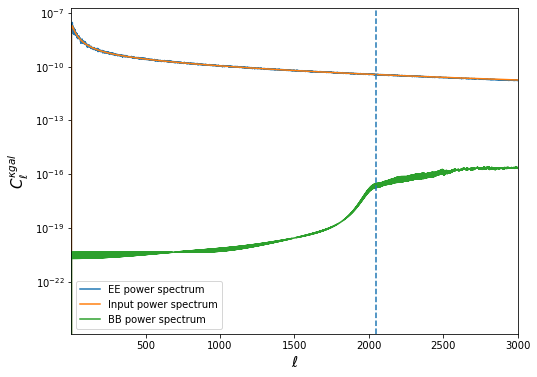

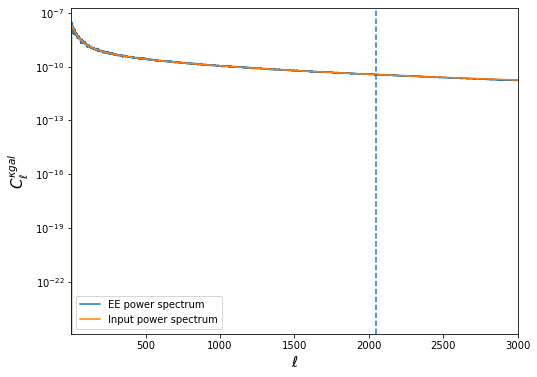

In [18]:

g1_map, g2_map = kappa2gamma(kappa_gal, nside, lmax)

#By definition, the power spectrum of the shear must be == to the power spectrum of the convergence:
#As gamma1 and gamma2 are spin2 quantity, let's just add a zero field as the scalar quantity:
cl_shear = hp.anafast((np.zeros(npix),g1_map,g2_map), lmax = lmax)
cl_ee = cl_shear[1]
cl_bb = cl_shear[2]
cl_eb = cl_shear[4]

plt.figure(figsize=(8,6))
plt.plot(cl_ee, label='EE power spectrum')
plt.plot(cl_kgal_th,label='Input power spectrum')
plt.plot(cl_bb, label='BB power spectrum')
# plt.plot(cl_eb, label='EB power spectrum')
plt.axhline(color='k')
plt.axvline(2*nside, linestyle='dashed')
plt.xlim(2,3000)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}^{\kappa gal}$',fontsize=15)


plt.figure(figsize=(8,6))
plt.plot(cl_ee, label='EE power spectrum')
plt.plot(cl_kgal_th,label='Input power spectrum')
plt.axhline(color='k')
plt.axvline(2*nside, linestyle='dashed')
plt.xlim(2,3000)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}^{\kappa gal}$',fontsize=15)


#Alright, there is a non-zero EB-leakage (but it seems to be very small- but relevant to check how bad it can be to the E modes)
#but overall it seems that the EE mode is reasonably in a good agreement

/home/gmarques/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '$C_{\\ell}^{EE}/C_{\\ell}^{kk,in}$')

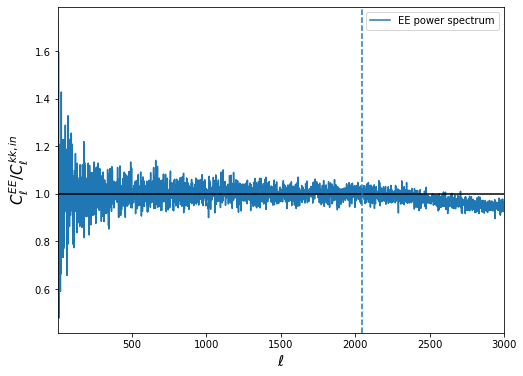

In [19]:

plt.figure(figsize=(8,6))
plt.plot(cl_ee[:-1]/cl_kgal_th, label='EE power spectrum')
plt.axhline(1,color='k')
plt.axvline(2*nside, linestyle='dashed')
plt.xlim(2,3000)
plt.legend()
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}^{EE}/C_{\ell}^{kk,in}$',fontsize=15)